<p>
  <b>AI Lab: Deep Learning for Computer Vision</b><br>
  <b><a href="https://www.wqu.edu/">WorldQuant University</a></b>
</p>

<div class="alert alert-success" role="alert">
  <p>
    <center><b>Usage Guidelines</b></center>
  </p>
  <p>
    This file is licensed under <a href="https://creativecommons.org/licenses/by-nc-nd/4.0/">Creative Commons Attribution-NonCommercial-NoDerivatives 4.0 International</a>.
  </p>
  <p>
    You <b>can</b>:
    <ul>
      <li><span style="color: green">✓</span> Download this file</li>
      <li><span style="color: green">✓</span> Post this file in public repositories</li>
    </ul>
    You <b>must always</b>:
    <ul>
      <li><span style="color: green">✓</span> Give credit to <a href="https://www.wqu.edu/">WorldQuant University</a> for the creation of this file</li>
      <li><span style="color: green">✓</span> Provide a <a href="https://creativecommons.org/licenses/by-nc-nd/4.0/">link to the license</a></li>
    </ul>
    You <b>cannot</b>:
    <ul>
      <li><span style="color: red">✗</span> Create derivatives or adaptations of this file</li>
      <li><span style="color: red">✗</span> Use this file for commercial purposes</li>
    </ul>
  </p>
  <p>
    Failure to follow these guidelines is a violation of your terms of service and could lead to your expulsion from WorldQuant University and the revocation your certificate.
  </p>
</div>

### Setup and Data Loading

As before, we'll import the packages we'll need in this notebook. Most of these are the same as the previous notebook, but there are a few new ones.

In [1]:
import os

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sklearn.model_selection
import torch
import torch.nn as nn
import torch.optim as optim
import torchinfo
import torchvision
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from torch.utils.data import DataLoader
from torchinfo import summary
from torchvision import datasets, transforms
from tqdm import tqdm

Let's print out the versions of our packages again. If we come back to this later, we'll know what we used.

In [2]:
print("torch version : ", torch.__version__)
print("torchvision version : ", torchvision.__version__)
print("torchinfo version : ", torchinfo.__version__)
print("numpy version : ", np.__version__)
print("matplotlib version : ", matplotlib.__version__)

!python --version

torch version :  2.2.2+cu121
torchvision version :  0.17.2+cu121
torchinfo version :  1.8.0
numpy version :  1.26.3
matplotlib version :  3.9.2
Python 3.11.0


We should be running on GPUs, so the device should be `cuda`.

In [3]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using {device} device.")

Using cuda device.


### Loading Data

We'll be working with the same undersampled dataset we created in an earlier lesson, in the `data_p2/data_undersampled/train` directory. We'll also be applying the same transformations. Let's load it.

**Task 2.4.1:** Create the `data_dir` variable for the undersampled training data.

In [4]:
data_dir = "data_p2/data_undersampled/train"

print("Data directory:", data_dir)

Data directory: data_p2/data_undersampled/train


We'll be applying the same transformations we have been all along:

- Convert grayscale images to RGB
- Resize images to $224$ x $224$
- Convert images to PyTorch tensors
- Normalize the tensors

Here's the function we've been using to convert to RGB.

In [5]:
class ConvertToRGB(object):
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img

**Task 2.4.2:** Create the set of transformations listed above. Use the means and standard deviations from the `022-explore-dataset` lesson.

In [7]:
mean=[0.4326, 0.4952, 0.3120]
std=[0.2179, 0.2214, 0.2091]

In [16]:
transform_normalized = transforms.Compose(
    [
        ConvertToRGB(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
      
    ]
)
transform_normalized

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.4326, 0.4952, 0.312], std=[0.2179, 0.2214, 0.2091])
)

**Task 2.4.3:** Use `ImageFolder` to read the files in our `data_dir` and apply our transformations.

In [17]:
dataset = datasets.ImageFolder(data_dir, transform_normalized)

dataset

Dataset ImageFolder
    Number of datapoints: 7615
    Root location: data_p2/data_undersampled/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.4326, 0.4952, 0.312], std=[0.2179, 0.2214, 0.2091])
           )

As a double check, we should have the same $5$ classes as before, with Cassava plants.

In [18]:
classes = dataset.classes
classes

['cassava-bacterial-blight-cbb',
 'cassava-brown-streak-disease-cbsd',
 'cassava-green-mottle-cgm',
 'cassava-healthy',
 'cassava-mosaic-disease-cmd']

We should be using the undersampled data. Let's also make sure that the classes are balanced. We can use the `class_counts` function we've used in previous lessons.

In [19]:
from training import class_counts

**Task 2.4.4:** Use the `class_counts` function on our dataset to verify all classes have the same number of observations.

In [20]:
counts = class_counts(dataset)
counts

  0%|          | 0/7615 [00:00<?, ?it/s]

cassava-bacterial-blight-cbb         1523
cassava-brown-streak-disease-cbsd    1523
cassava-green-mottle-cgm             1523
cassava-healthy                      1523
cassava-mosaic-disease-cmd           1523
dtype: int64

<Axes: >

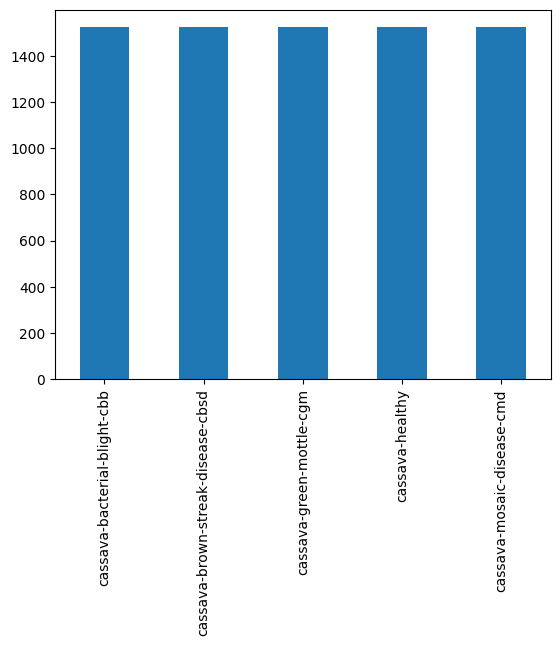

In [22]:
counts.plot(kind="bar")

As you'll see later, we'll be handling training and validation differently in this notebook. For now, we'll use the full dataset. Let's make a `DataLoader` for the dataset.

**Task 2.4.5:** Create a `DataLoader` for the dataset. Use a batch size of $32$.

In [21]:
batch_size = 32
dataset_loader = DataLoader(dataset, batch_size)

print(f"Batch shape: {next(iter(dataset_loader))[0].shape}")

Batch shape: torch.Size([32, 3, 224, 224])


### Implementing Transfer Learning

We have our data, now we need a model. In the last lesson and the previous project, we built our own. But classifying images is a very common task, many people have already done it. Those people have already spent the time and computing resources to design and train a model. If we can get their architecture and weights, we can use theirs!

Thankfully, many models like this are publicly available. These are called _pre-trained models_. PyTorch comes with some included. Here we'll load a model called `resnet`.

In [23]:
model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)

This model is very large, and took a long time to train. Let's look at the model summary to see what we're working with. To get a full summary, we'll need to provide the model with the shape of our data.

**Task 2.4.6:** Get the shape of the `test_batch` of data, and use that as the `input_size` when you call `summary` on the model.

In [6]:
summary?

Signature:
summary(
    model: 'nn.Module',
    input_size: 'INPUT_SIZE_TYPE | None' = None,
    input_data: 'INPUT_DATA_TYPE | None' = None,
    batch_dim: 'int | None' = None,
    cache_forward_pass: 'bool | None' = None,
    col_names: 'Iterable[str] | None' = None,
    col_width: 'int' = 25,
    depth: 'int' = 3,
    device: 'torch.device | str | None' = None,
    dtypes: 'list[torch.dtype] | None' = None,
    mode: 'str | None' = None,
    row_settings: 'Iterable[str] | None' = None,
    verbose: 'int | None' = None,
    **kwargs: 'Any',
) -> 'ModelStatistics'
Docstring:
Summarize the given PyTorch model. Summarized information includes:
    1) Layer names,
    2) input/output shapes,
    3) kernel shape,
    4) # of parameters,
    5) # of operations (Mult-Adds),
    6) whether layer is trainable

NOTE: If neither input_data or input_size are provided, no forward pass through the
network is performed, and the provided model information is limited to layer names.

Args:
    model 

In [24]:
test_batch = next(iter(dataset_loader))[0]
batch_shape = test_batch.shape

# Create the model summary
summary(model, batch_shape)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 1000]                --
├─Conv2d: 1-1                            [32, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        128
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 256, 56, 56]         --
│    └─Bottleneck: 2-1                   [32, 256, 56, 56]         --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          4,096
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]          --
│ 

<div class="alert alert-info" role="alert">
You may notice that this model has about 25 million parameters. This is quite similar to the model we made in the previous lesson. You'd expect it to have more, since it has so many layers. 
<br><br>
In our last lesson, almost all of the parameters were in the first linear layer. But this model is organized differently, so the parameters are more spread out. Even with about the same number of parameters, this model will be <i>tremendously</i> slower to train, as the structure is more complex and the layers are more computationally expensive. Good thing we don't have to train it!
</div>

This model has _many_ layers! We don't need to worry about the details, since we won't be building or training it. In fact, we need to mark the layers to tell them _not_ to train.

All models come with a `parameters` method that gives us access to the model's weights. We can loop through this to set `requires_grad = False` on all of the weights. This tells the system not to take their derivatives, so backpropagation doesn't update them.

In [25]:
for params in model.parameters():
    params.requires_grad = False

This model was trained for a different purpose than we need it for. We can see this by looking at the shape of the output. But our model is very large, so before we run it we'll want to make sure both the model and the `test_batch` are on the GPU.

**Task 2.4.7:** Move the model and the `test_batch` to our `device`.

In [26]:
# Move the model to device
model.to(device)

# Move our test_batch to device
test_batch_cuda = test_batch.to(device)

print("Test batch is running on:", test_batch_cuda.device)

Test batch is running on: cuda:0


Now we should be able to check.

In [27]:
model?

Signature:       model(*args, **kwargs)
Type:            ResNet
String form:    
ResNet(
           (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
           <...> iveAvgPool2d(output_size=(1, 1))
           (fc): Linear(in_features=2048, out_features=1000, bias=True)
           )
File:            /usr/local/lib/python3.11/site-packages/torchvision/models/resnet.py
Docstring:       <no docstring>
Class docstring:
Base class for all neural network modules.

Your models should also subclass this class.

Modules can also contain other Modules, allowing to nest them in
a tree structure. You can assign the submodules as regular attributes::

    import torch.nn as nn
    import torch.nn.functional as F

    class Model(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(1, 20, 5)
            self.conv2 = nn.Conv2d(20, 20, 5)

        def forward(self, x):
            x = F.relu(self.conv1(x))
      

**Task 2.4.8:** Run the model on the test batch, and check the shape of the output.

In [29]:
model_test_out = model(test_batch_cuda)
model_test_shape = model_test_out.shape

print("Output shape:", model_test_shape)

Output shape: torch.Size([32, 1000])


### Modifying the Network to Our Task

This model was meant for a task with $1000$ classes. We only have $5$, so that's not going to work for us. Even if they were the same number of classes, it wouldn't work, since it was trained for a different task.

But we can replace the final layer with our own network. The rest of the network will still do the image processing, and provide our layer with good inputs. Our network will do the final classification. This process of using most of an already trained model is called _transfer learning_.

Which layer is the last one? We can access the list of layers with the `named_modules` method. It returns a generator, which we can convert to a list to get the last element.

In [30]:
list(model.named_modules())[-1]

('fc', Linear(in_features=2048, out_features=1000, bias=True))

This looks right — it's a linear layer with $1000$ neurons (and hence outputs). The thing we really wanted to know was its name — `fc`. Now we can access it with `model.fc`. We'll need to know how many inputs it takes to be able to replace it. It's a `Linear` layer, so the number of inputs it takes is recorded in the `in_features` attribute.

**Task 2.4.9:**: Get the number of input features into the last layer by using `in_features` attribute. Save that to the `in_features` variable.

In [31]:
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [34]:
in_features = model.fc.in_features
in_features

2048

Let's build a network to replace it. It will need to take the same inputs, but produce _our_ outputs. 

We'll make a small network to do our classification. As before, we'll build it with the `Sequential` container.

In [33]:
classifier = torch.nn.Sequential()

We'll build up a network with the following structure

- Linear layer of 256 neurons
- ReLU
- Dropout
- Linear layer of 5 neurons for output

**Task 2.4.10:** Make a `Linear` layer that takes the same inputs as the `fc` layer and produces $256$ outputs. Add it to our classifier network.

In [36]:
classification_layer = torch.nn.Linear(2048, 256)
classifier.append(classification_layer)

# Add the layer to our classifier

Sequential(
  (0): Linear(in_features=2048, out_features=256, bias=True)
)

Let's add the ReLU and the Dropout.

We'll use the default settings for Dropout, which offer a good balance between speed and preventing overfitting.

In [37]:
classifier.append(torch.nn.ReLU())
classifier.append(torch.nn.Dropout())

Sequential(
  (0): Linear(in_features=2048, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
)

And we can finish off our classifier with an output layer that produces one output for each of our classes.

**Task 2.4.11:** Make a `Linear` layer that takes the previous layer as input and produces $5$ outputs. Add it to our classifier network.

In [39]:
output_layer = torch.nn.Linear(256, 5)

# Add the layer to our classifier
classifier.append(output_layer)

Sequential(
  (0): Linear(in_features=2048, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=256, out_features=5, bias=True)
)

And now we want to do two things: remove the output layer in `ResNet` that's wrong for us, and add our classifier. We can do both at the same time by replacing `fc` with our classifier network.

In [40]:
model.fc = classifier

Let's see what the model now looks like. You can check the number of outputs by looking at the last line in the Output shapes column of the summary, we should be getting `[32, 5]` (for our batch of 32 images).

**Task 2.4.12:** Call summary on the model again. You can use the same `batch_shape` we used earlier.

In [42]:
# Create the model summary
summary(model, batch_shape)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 5]                   --
├─Conv2d: 1-1                            [32, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        (128)
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 256, 56, 56]         --
│    └─Bottleneck: 2-1                   [32, 256, 56, 56]         --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          (4,096)
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          (36,864)
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]   

Our new classifier won't be trained, so we'll have to train it. But it's much faster to train two small layers than an entire, huge network!

### K-fold Cross-Validation

Normally, at this point we'd split our data into training and validation sets. We'd train on the training set, and check that the model is performing well on the validation set. This lets us see how the model does on data it wasn't trained on and detect overfitting. Instead, we'll use _k-fold cross-validation_, which splits our data into $k$ "folds".

PyTorch doesn't have a dedicated tool for this. Instead, we'll use the `KFold` splitting tool from `scikit-learn`. It needs to know how many splits to make and if we want to shuffle the order of observations. Since our data is ordered (we get all of one class, then all of the next class, and so on), we do want to shuffle. We have been using 20% of our data for validation so far, so let's keep doing that.

**Task 2.4.13:** Set $k$ to get each fold to be 20% of the data. How many parts should we break the data into to get that?

<div class="alert alert-info" role="alert">
    <p><b>About random number generators</b></p>
<p>The following cell adds a <code>random_state=42</code> line of code that is not present in the video. This is something we have added to make sure you always get the same results in your predictions. Please don't change it or remove it.
</p>
</div>

In [43]:
k = 5

kfold_splitter = sklearn.model_selection.KFold(n_splits=k, shuffle=True, random_state=42)

train_nums, val_nums = next(kfold_splitter.split(range(100)))
fold_fraction = len(val_nums) / (len(train_nums) + len(val_nums))
print(f"One fold is {100*fold_fraction:.2f}%")

One fold is 20.00%


<div class="alert alert-info" role="alert">
Cross validation is pretty common with smaller models, but often not used with neural networks. If it gives a better measure of how our model is doing, why wouldn't we? Because of how it works — we will fit our model once for each fold. It's pretty common to see $k$ values between $3$ and $10$. That means our model will take $3$ to $10$ times as long to train! If our model trains in a few minutes, that's no problem. But large neural networks can take hours or days (or more!) to train. In that case, it's often seen as too high of a price to pay for a better validation measure.
</div>

### Training with k-fold

We'll need to adjust our training somewhat to use cross-validation. We won't be using a fixed training and validation set. Instead, we'll get a training set of 80% of the data, and a validation set of 20% of the data from our splitter. We'll train with this, then reset our model and get the next training and validation sets and repeat.

We'll still be able to reuse most of our code from before. Let's import it from the `training.py` file.

In [44]:
from training import predict, train

We'll be using the `train` function that we've used a few times now. Let's remind ourselves of what it needs.

In [45]:
train?

Signature:
train(
    model,
    optimizer,
    loss_fn,
    train_loader,
    val_loader,
    epochs=20,
    device='cpu',
    use_train_accuracy=True,
)
Docstring: <no docstring>
File:      /app/training.py
Type:      function

We have the model, and with k-fold we'll need to create the training and validation loaders as we go. Let's create the optimizer and the loss function. We'll use the same ones we've been using so far, `Adam` and `CrossEntropyLoss`.

**Task 2.4.14:** Define cross-entropy as the loss function and set the Adam optimizer to be the optimizer. You can use the default learning settings.

In [46]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

To get an accurate measure, we'll need to reset the model when we change which fold is the validation set. Otherwise the model _will_ have seen that data, which means it's not a good validation set!

We only want to reset the part we added, since we're not training the rest of the model. We can do that using `reset_parameters` on just the layers that we added. 

`Sequential` named the layers for us, as `"0"`, `"1"`, etc.

In [47]:
model.fc

Sequential(
  (0): Linear(in_features=2048, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=256, out_features=5, bias=True)
)

We'll make a function to reset them, to simplify our training code.

In [48]:
def reset_classifier(model):
    model.fc.get_submodule("0").reset_parameters()
    model.fc.get_submodule("3").reset_parameters()

<div class="alert alert-info" role="alert">
We were quite specific here. There are other ways we could have organized this. We could have built something that generically resets all parameters, and called that on just the part we added instead of the bigger model. But that code is a fair bit more complex, and runs the danger of accidentally resetting the <i>whole</i> model. We chose a safer but less portable route.
</div>

We have one more thing to set before we can start training. We'll need to decide how many epoch to train our model. Through some testing, we found the model stops improving by the $7$ epoch mark. To prevent this from becoming overfitting, we'll do a form of early stopping and only train for $6$ epochs.

**Task 2.4.15:** Set `num_epochs` so the model only trains for $6$ epochs.

In [49]:
num_epochs = 6

We're ready. For k-fold, we'll train in a loop that will run $k$ times. In each run, we'll have one fold as our validation set and the rest as training.

On each loop we'll do a few things:

- Get which observations are in the training set and which are in the validation set from our k-fold splitter.
- Create a training and a validation data loader
- Reset the classifier part of our model
- Train the model with this training set and validation set
- Record the losses and accuracies from the training process

We're setting an option on the `train` function we haven't used before: `use_train_accuracy=False`. We won't get the accuracy on the training data, but it will make the training process faster.

This next cell runs the training process. It can take quite a while.

<div class="alert alert-info" role="alert"> <strong>Regarding Model Training Times</strong>

The following cell will train the model for 6 epochs, for each one of the 5 folds. This can take more than 60 minutes. Instead, we recommend you to skip the following cell and look at the next one that loads a pre-trained version of the cell model.

<b>We strongly recommend you to use the saved model instead of training your own.</b>
</div>

In [ ]:
# you can safely skip this cell and load the model in the next cell

training_records = {}
fold_count = 0

for train_idx, val_idx in kfold_splitter.split(np.arange(len(dataset))):
    fold_count += 1
    print("*****Fold {}*****".format(fold_count))

    # Make train and validation data loaders
    train_dataset = torch.utils.data.Subset(dataset, train_idx)
    val_dataset = torch.utils.data.Subset(dataset, val_idx)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Reset the model
    reset_classifier(model)

    # Train
    train_losses, val_losses, train_accuracies, val_accuracies = train(
        model,
        optimizer,
        loss_fn,
        train_loader,
        val_loader,
        epochs=num_epochs,
        device=device,
        use_train_accuracy=False,
    )

    # Save training results for graphing
    training_records[fold_count] = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "val_accuracies": val_accuracies,
    }

    print("\n\n")

*****Fold 1*****


Training:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 1
    Training loss: 1.25
    Validation loss: 1.07
    Validation accuracy: 0.57


Training:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 2
    Training loss: 1.05
    Validation loss: 1.03
    Validation accuracy: 0.58


Training:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 3
    Training loss: 0.97
    Validation loss: 0.99
    Validation accuracy: 0.59


Training:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 4
    Training loss: 0.89
    Validation loss: 1.01
    Validation accuracy: 0.58


Training:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 5
    Training loss: 0.85
    Validation loss: 1.01
    Validation accuracy: 0.60


Training:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]

**[RECOMMENDED]** Load the pre-trained model:

In [ ]:
model = torch.load("pretrained_model.pth", weights_only=False)
model.to(device)

We've also made available the `training_records` resulting from the pretrained model:

In [43]:
import pickle
with open('training_records.pkl', 'rb') as fp:
    training_records = pickle.load(fp)

### Model Performance

We gathered a lot of information as we were training. For each fold, we have the losses and accuracy at each training epoch. Let's visualize these. They were stored in a dictionary with a key for each fold, just numbered $1$ to $5$.

In [ ]:
print(type(training_records))
training_records.keys()

Each of values is another dictionary, with keys for each kind of information we tracked.

In [ ]:
print(type(training_records[1]))
training_records[1].keys()

Each of those values is a list with a loss or accuracy per epoch.

In [ ]:
training_records[1]["train_losses"]

We'll make a function to plot one kind of value for all folds.

In [ ]:
def plot_all_folds(data, measurement):
    for fold in data.keys():
        plt.plot(data[fold][measurement], label=f"Fold {fold}, {measurement}")
    plt.xlabel("Epochs")
    plt.legend()

Let's try it out on the training loss.

In [ ]:
plot_all_folds(training_records, "train_losses")

Looks like all the folds were very similar. That's good, we expect them to be. Let's look at the other measures.

**Task 2.4.16:** Use the `plot_all_folds` function to look at the validation losses (`val_losses`).

In [ ]:
plot_all_folds(training_records, "val_losses")

**Task 2.4.17:** Use the `plot_all_folds` function to look at the validation accuracy (`val_accuracies`).

In [ ]:
# Plot the validation accuracies
plot_all_folds(training_record, "val_accuracies")

There's more variation between the folds in the validation metrics, but they're all fairly flat or getting a little worse at the end. This suggests our model is full trained, and we may be getting close to overfitting.

Usually the metrics that we actually look at are not the individual folds. Instead, we average the measurements from each fold together, for the last epoch.

In [ ]:
def fold_average(data, measurement):
    return np.mean([data[fold][measurement][-1] for fold in data])


for measurement in training_records[1].keys():
    avg_measure = fold_average(training_records, measurement)
    print(f"Averaged {measurement}: {avg_measure}")

Let's also make the confusion matrix to see how it did, and if specific classes are the issue. Usually we'd make the confusion matrix on a validation set. But we didn't do a normal train-validation split here. 

To get around this, we'll note how the k-fold worked. It created a training and validation split at each step, and trained the model. So right now, the model has been trained on the training set for the last fold. 

The `val_loader` variable should still be the validation set for that last fold. Let's use that. We can use the `predict` function from our `training.py` as we have in previous lessons. This gives us confidences, which we need to convert to actual predictions.


**Task 2.4.18:** Calculate the predictions for `val_loader`. Remember to set the device.

In [ ]:
# If you loaded the pre-trained model, make sure you have the correct validation set
_, val_idx = list(kfold_splitter.split(np.arange(len(dataset))))[-1]
val_dataset = torch.utils.data.Subset(dataset, val_idx)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [ ]:
predict?

In [ ]:
probabilities = predict(model, val_loader, device)
predictions = torch.argmax(probabilities, dim=1)

We'll pull the correct answers (the labels) to a list.

In [ ]:
targets = []

for _, labels in tqdm(val_loader):
    targets.extend(labels.tolist())

**Task 2.4.19:** Make the same confusion matrix we made in earlier lessons. You'll need to either move the `predictions` to `cpu` or convert them to a list. The labels will be our classes.

In [ ]:
cm = confusion_matrix(targets, predictions.cpu())

disp = ConfusionMatrixDissplay(co)

disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
plt.show();

### Saving the model

We'll save the model for future use, so we don't need to retrain it.

In [ ]:
torch.save(model, "model/resnet_k_folds")

### Conclusion

Good work! We have gained one of the most important abilities — we can now take advantage of the hard work of professionals. Experts put a lot of time and computing resources into training models, and transfer learning lets us use them for our own purposes. Here are the key takeaways:

- Many well trained networks are available publicly
- We can download them and modify the last layer to suit our specific task
- We only need to train the part we added
- Cross validation is an alternative way to measure how well our model performs

In the next lesson, we'll do a bit more transfer learning. We'll also look at callbacks, a powerful way of modifying the training process to better meet our needs.

---
This file &#169; 2024 by [WorldQuant University](https://www.wqu.edu/) is licensed under [CC BY-NC-ND 4.0](https://creativecommons.org/licenses/by-nc-nd/4.0/).